## Scikit-learn, unsupervised learning:
Use unsupervised learning to re-color a multicolor drawing with only two colors

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame as DF, Series as Ser
from matplotlib import pyplot as plt
from PIL import Image
from os import sys

from sklearn.cluster import KMeans

from save_figure_per_user import save_figure_per_user
from rgb_to_hex import rgb_to_hex
import os, platform

In [2]:
# Read the image
dir_path = sys.path[0] + '/'

# Comment out one of these:
png_path = dir_path + "function-fx-drawing.png"
#png_path = dir_path + "drawing-small.png"

img = Image.open(png_path)

# Convert to numpy array
png_array = np.asarray(img)
im_height, im_width = (img.height, img.width)

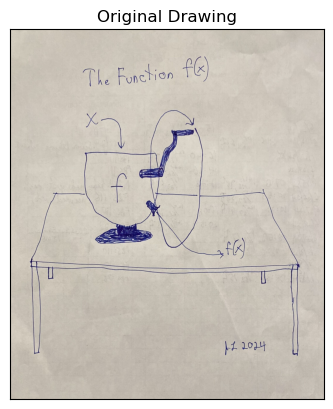

In [3]:

def show_image(img):
    '''Show the image'''
    plt.tick_params(
    axis='both',       # changes apply to both axes
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,        # ticks along the left edge are off
    labelleft=False,   # labels along the left edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    plt.title("Original Drawing")
    plt.imshow(img, cmap="gray")
    plt.show()

show_image(img)

### Convert image to numpy RGB-array

In [4]:
# Convert to array of RGB-triples (delete alpha-values)
img_rgb = png_array.ravel().reshape(im_height*im_width, 4)[:, :3]

In [5]:
# Convert numpy array of image to dataframe
features = ['r', 'g', 'b']
df = DF(img_rgb)
df.columns = features
df_display = pd.concat([df.head(3), df.tail(3)])
df_display

,r,g,b
0,212,206,192
1,212,206,192
2,212,206,192
2001405,201,193,183
2001406,202,195,187
2001407,200,197,192


Save image? ('' = No, ~'' = Yes):  


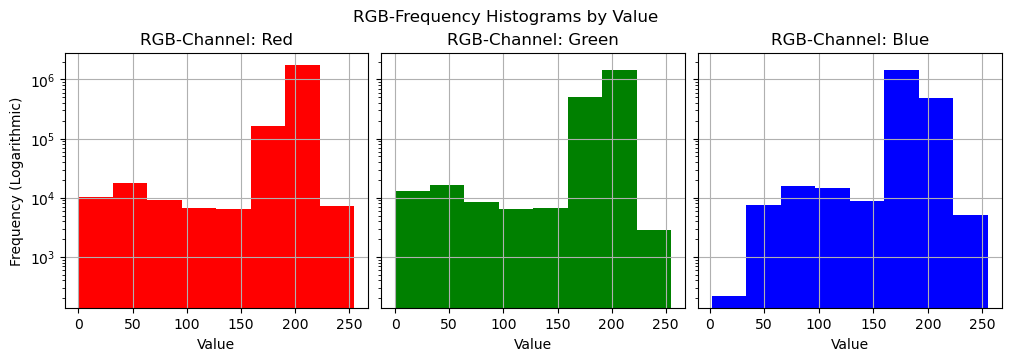

In [6]:
# Make histograms of RGB-colors' frequency by value

colornames = ['Red', 'Green', 'Blue']
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, 
                       layout='constrained')
plt.suptitle("RGB-Frequency Histograms by Value")
for idx, df_onefeature in list(enumerate([df[feature] \
                            for feature in features])):
    ax[idx].hist(df_onefeature, bins=8, color=features[idx])
    ax[idx].grid()
    ax[idx].set_yscale(value='log')
    ax[idx].set_xlabel('Value')

    if idx == 0:
        ax[idx].set_ylabel('Frequency (Logarithmic)')
    ax[idx].set_title('RGB-Channel: ' + colornames[idx])
save_figure_per_user("Fig-1-RGB-Frequency-Histograms")
plt.show()

Save image? ('' = No, ~'' = Yes):  


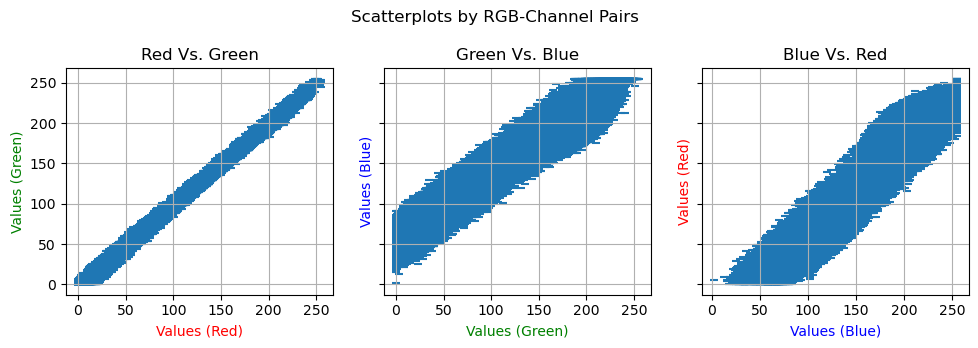

In [7]:
# Perform K-means clustering on pairs of RGB-colors

# First, do scatter graphs:
color_pairs = [['r', 'g'], ['g', 'b'], ['b', 'r']]
colorname_pairs = [['Red', 'Green'], ['Green', 'Blue'], 
                   ['Blue', 'Red']]
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, 
                       layout='tight')
plt.subplots_adjust(wspace=10)
plt.suptitle("Scatterplots by RGB-Channel Pairs")
for idx, df_2cols in list(enumerate([df.loc[:, 
                c_pair] for c_pair in color_pairs])):
    ax[idx].scatter(df_2cols.iloc[:, 0], df_2cols.iloc[:, 1], 
                    marker='_')
    ax[idx].grid()
    ax[idx].set_xlabel('Values (' + colorname_pairs[idx][0] + ')', 
                       color=colorname_pairs[idx][0])
    ax[idx].set_ylabel('Values (' + colorname_pairs[idx][1] + ')', 
                       color=colorname_pairs[idx][1])
    ax[idx].set_title(colorname_pairs[idx][0] + ' Vs. ' + \
                      colorname_pairs[idx][1])
    
if platform.system() == "Darwin":
    ! osascript -e 'beep'
    
save_figure_per_user("Fig-2-Scatterplots-RGB-Color-Channels")
plt.show()

idx: 0
idx: 1
idx: 2


Save image? ('' = No, ~'' = Yes):  


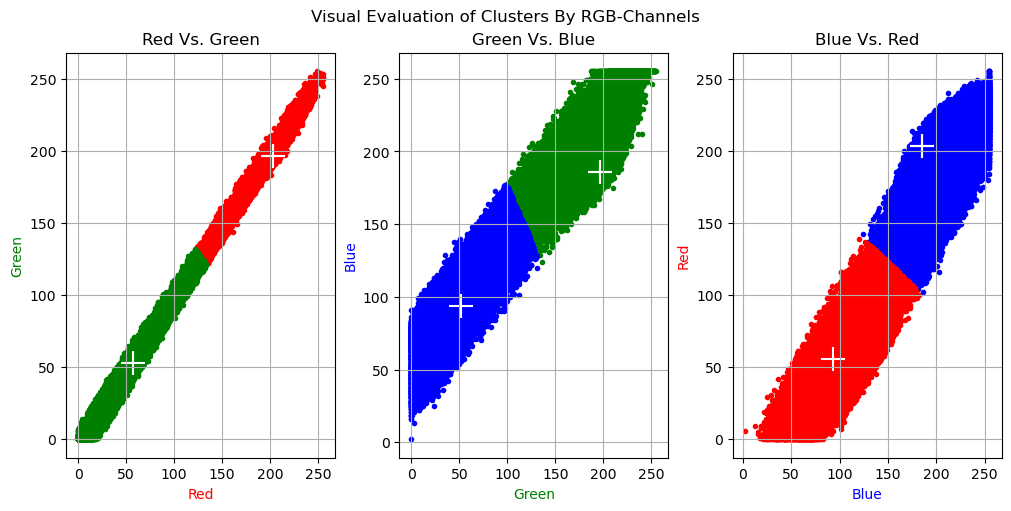

In [74]:
# Cluster the pixels by pairs of RGB channels:

# Make an instance of KMeans
kmeans = KMeans(n_clusters=2, random_state=1)

# Visually evaluate the clusters using pairs of RGB colors
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=3, layout='constrained')
plt.suptitle("Visual Evaluation of Clusters By RGB-Channels")

# For each of the two reclassified labels, extract and plot separately
# the points given that label; also plot their centroids
for idx, df_2cols in list(enumerate([df.loc[:, 
                c_pair] for c_pair in color_pairs])):
    print("idx:", idx)  # debugging
    
    x = df.loc[:, color_pairs[idx]]
    labels = kmeans.fit_predict(x)
    centroids = kmeans.cluster_centers_
    
    for i_twocolors in (0, 1):
        indices = np.array(np.where(
            labels==i_twocolors))[0] # select subset of labels matching current index
        x_indexed = DF(x, index=indices)
    
        ax[idx].scatter(x_indexed[color_pairs[idx][0]], x_indexed[color_pairs[idx][1]],
                       color=color_pairs[idx][i_twocolors], marker='.')
        ax[idx].scatter(centroids[:,0], centroids[:,1], s = 300, 
                        marker = '+', c = 'white')

    ax[idx].grid()
    ax[idx].set_xlabel(colorname_pairs[idx][0], color=colorname_pairs[idx][0])
    ax[idx].set_ylabel(colorname_pairs[idx][1], color=colorname_pairs[idx][1])
    ax[idx].set_title(colorname_pairs[idx][0] + ' Vs. ' + \
                       colorname_pairs[idx][1])

save_figure_per_user("Fig-3-Vis-Eval-Clusters")
plt.show()


In [10]:
# Choose colors for output image

darkcolor, lightcolor = [44, 80, 129], [234, 231, 223]

x = df.loc[:, ['r', 'b']]
kmeans.fit(x) # we _do_ need to refit
predictions = kmeans.predict(x)
print("predictions[0]:", predictions[0])

# Although KMeans correctly separates the points, its classes
# may lead to the opposite color scheme than what we want.
# To prevent this, we need to make sure that predictions[0] = 0.
# If not, reverse the predictions.
if predictions[0] != 0:
    predictions = 1 - predictions

df_predics = DF(predictions)
df_predics.columns = ['Class']

# Create new dataframe containing points' RGB-colors
rgb = [[lightcolor] if i==0 else [darkcolor] for i in predictions]
df_rgb = DF(rgb)
df_rgb.columns = ['RGB']

# Incorporate it into dataset
df_class_rgb = pd.concat([df, df_predics, df_rgb], axis=1)
display(pd.concat([df_class_rgb.head(2), df_class_rgb.tail(2)]))

predictions[0]: 0


,r,g,b,Class,RGB
0,212,206,192,0,"[234, 231, 223]"
1,212,206,192,0,"[234, 231, 223]"
2001406,202,195,187,0,"[234, 231, 223]"
2001407,200,197,192,0,"[234, 231, 223]"


In [11]:
dfX = df_class_rgb['RGB']

# Convert it into a numpy array
dfX_ar = np.array(dfX)

# Convert the list elements to  numpy arrays, dropping alphas
ar = np.array([v[:3] for v in dfX_ar])

# Final array to be displayed: reshape and convert dtype
ar_rshp = ar.reshape(im_height, im_width, 3).astype(np.uint8)
print("Output array shape:", ar_rshp.shape)
print("Output array dtype:", ar_rshp.dtype)

Output array shape: (1536, 1303, 3)
Output array dtype: uint8


In [12]:
def thicken_dark_lines(a):
    # There are two RGB-triplets, t_light and t_dark.
    # We're sure the top left triplet is t_light
    
    def get_t_dark(a, t_light):
        ''' return the first triplet that isn't t_light'''
        print("im_height:", im_height, "im_width:", im_width)
        for i in range(im_height):
            for j in range(im_width):
                if list(a[i][j]) != t_light:
                    print('Found: list(a[' + str(i) + '][' + \
                        str(j) + ']:', list(a[i][j]))
                    return list(a[i][j])
                    
    t_light = list(a[0][0])
    t_dark = get_t_dark(a, t_light)

    # to thicken the lines, make any triplets above or left
    # of a dark triplet dark as well
    for i in range(1, im_height-1):
        for j in range(1, im_width-1):
            if list(a[i][j]) == t_dark:
                a[i-1][j] = a[i][j-1] = t_dark

thicken_dark_lines(ar_rshp)

im_height: 1536 im_width: 1303
Found: list(a[114][789]: [44, 80, 129]


Save image? ('' = No, ~'' = Yes):  


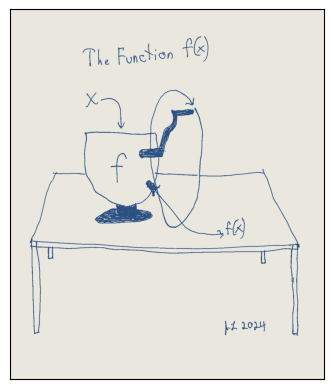

In [13]:

fig, ax = plt.subplots()

plt.tick_params(
axis='both',       # changes apply to both axes
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
left=False,        # ticks along the left edge are off
labelleft=False,   # labels along the left edge are off
labelbottom=False) # labels along the bottom edge are off

ax.imshow(ar_rshp)
save_figure_per_user("Fig-4-function-fx-recolored")
plt.show()

Save image? ('' = No, ~'' = Yes):  


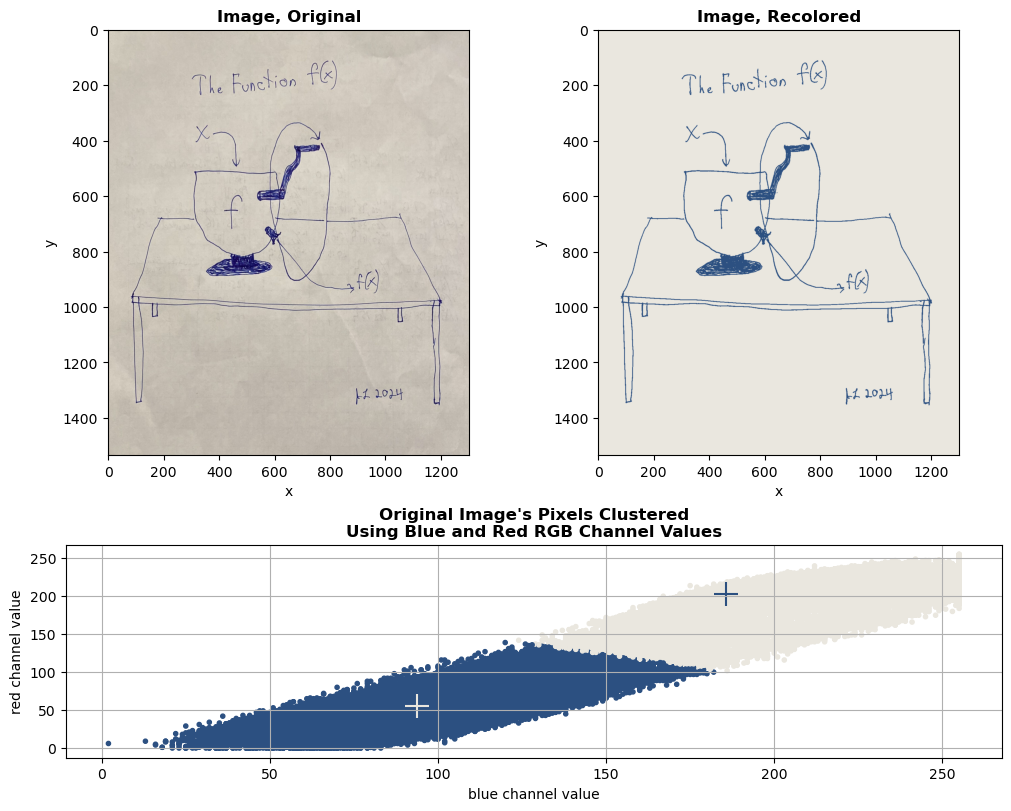

In [14]:
# Create a grid display showing input and output images,
# clusters with centroids

labels_br = ['b', 'r']
colormap2 = np.array([rgb_to_hex(lightcolor), 
    rgb_to_hex(darkcolor)])

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 8), layout="constrained")
gs = GridSpec(3, 4, figure=fig)

ax1 = fig.add_subplot(gs[0:2, 0:2])
ax1.set_title("Image, Original", fontweight=600 )
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.imshow(img)

ax2 = fig.add_subplot(gs[0:2, 2:])
ax2.set_title("Image, Recolored", fontweight=600)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.imshow(ar_rshp)

ax3 = fig.add_subplot(gs[2, :])
ax3.set_title("Original Image's Pixels Clustered\n"
    "Using Blue and Red RGB Channel Values", fontweight=600)
ax3.grid()
ax3.scatter(x[labels_br[0]], x[labels_br[1]], 
            c=colormap2[labels], marker='.')
ax3.scatter(centroids[:,0], centroids[:,1], s = 300, 
            marker = '+', c = [np.array(darkcolor)/256, 
            np.array(lightcolor)/256])

ax3.set_xlabel('blue channel value')
ax3.set_ylabel('red channel value')

save_figure_per_user("Fig-5-combined-images-and-clusters")
plt.show()